# A/B测试：软件销售价格测试

软件公司xyz的产品销售价格为39美金。为提高总体销售额，产品经理对产品价格做了一次A/B test：对66%的用户维持原价格，对其余33%的用户将价格提高到59美金。初步测试已结束，现分析数据已尝试解答以下问题：

1.公司是否应当将价格提高至59美金？
2.有哪些用户特征对转化率有影响？

整个notebook分为下面几个部分：

1.数据清洗与整理
2.A/B test样本的随机性检查
3.解答问题

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind 
import seaborn as sns

A. 数据清洗与整理

In [2]:
#对数据做初步梳理
user_table = pd.read_csv('C:/Users/xutia/Downloads/user_table.csv')
test_results = pd.read_csv('C:/Users/xutia/Downloads/test_results.csv')

In [3]:
user_table.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [4]:
user_table['country'].unique()

array(['USA'], dtype=object)

In [5]:
user_table['city'].value_counts()

New York       25748
Chicago         7153
Houston         6706
San Antonio     4633
Los Angeles     4141
               ...  
New Milford        1
East Lake          1
Ocala              1
Costa Mesa         1
Cerritos           1
Name: city, Length: 923, dtype: int64

In [6]:
test_results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [7]:
test_results['source'].value_counts()

direct_traffic     60357
ads-google         59379
ads_facebook       53396
ads_other          29876
seo-google         23175
ads-bing           22873
seo_facebook       21205
friend_referral    20695
seo-other           9260
ads-yahoo           7583
seo-yahoo           6848
seo-bing            2153
Name: source, dtype: int64

In [8]:
test_results['device'].value_counts()

mobile    186471
web       130329
Name: device, dtype: int64

In [9]:
test_results['operative_system'].value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: operative_system, dtype: int64

整个数据集里的用户信息包括：用户的地理位置，登陆时间，通过何种渠道接触到网站，操作系统与操作平台，所看到的产品价格以及是否被转化成付费用户。

所有用户均来自美国，操作平台分为移动端和网页端，操作系统包括所有常见系统，marketing渠道包括Facebook，Google，Bing，Yahoo，其他非主流平台的广告与SEO，以及现有客户的referral。

In [10]:
#将两个数据集合并
all_data=test_results.merge(user_table,left_on='user_id',right_on='user_id')

In [11]:
all_data.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
city                0
country             0
lat                 0
long                0
dtype: int64

In [12]:
#因为所有用户均来自美国，决定删除国家特征。
all_data=all_data.drop('country',axis=1)

In [13]:
all_data[['price','test','user_id']].groupby(['test','price']).count()

user_id
test price         
0    39      176241
     59         187
1    39         135
     59       99053

数据出现下列问题:test=0 的用户不应该出现price=59。相对的，test=1的用户不应该看见price=39.

鉴于错误数据量占总量本较少，决定删掉此类错误数据。

In [14]:
a= ((all_data['price']==59) & (all_data['test']==1))
b =  ((all_data['price']==39) & (all_data['test']==0))
all_data=all_data[a|b]

In [15]:
#建立销售额特征
all_data['revenue']=all_data['price']*all_data['converted']
#数据整理结束

B. A/B test样本的随机性检查

In [16]:
plt.style.use('default')
%matplotlib inline

In [17]:
#a.渠道的随机性检查
tmp = all_data.groupby('test')['source'].value_counts(normalize=True).unstack()
tmp

source,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.071850,0.186495,0.023604,0.167725,0.095460,0.191528,0.064769,0.006548,0.074534,0.029068,0.021703,0.066715
1,0.072557,0.188556,0.024290,0.169283,0.093051,0.189444,0.066429,0.007178,0.070629,0.029469,0.021504,0.067610


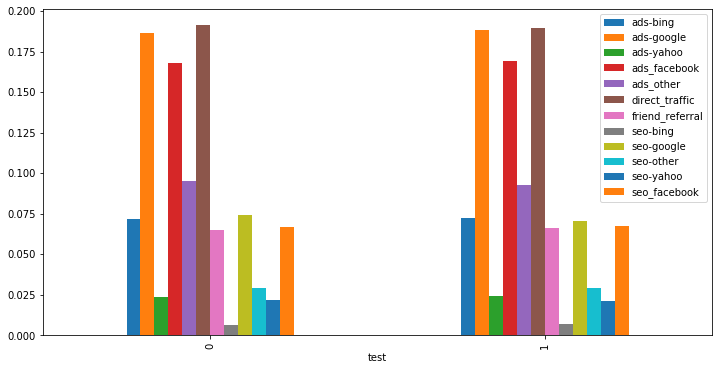

In [18]:
    #渠道客户分布
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind = 'bar',ax=ax).legend(loc=1, prop={'size': 10})
plt.show()

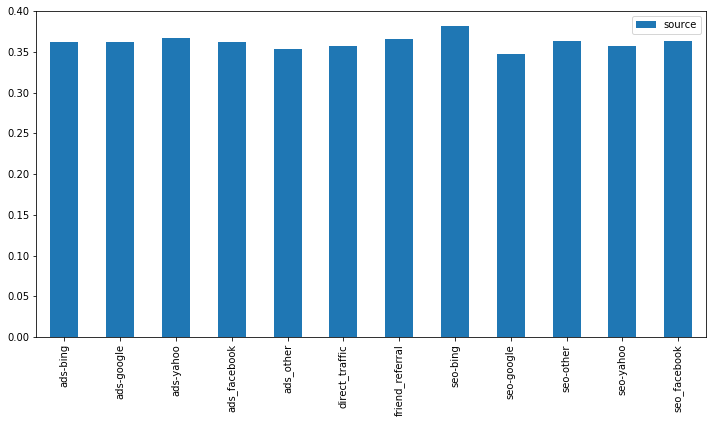

In [19]:
tmp = all_data.loc[all_data['test']==1]['source'].value_counts()/all_data['source'].value_counts()
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind = 'bar',ax=ax).legend(loc=1, prop={'size': 10})
plt.show()

In [20]:
#b. 操作平台的随机性检查

In [21]:
tmp = all_data.groupby('test')['operative_system'].value_counts(normalize=True).unstack()
tmp

operative_system,android,iOS,linux,mac,other,windows
test,,,,,,
0,0.238180,0.304736,0.010945,0.081008,0.052133,0.312998
1,0.234905,0.294570,0.017173,0.076000,0.049781,0.327572


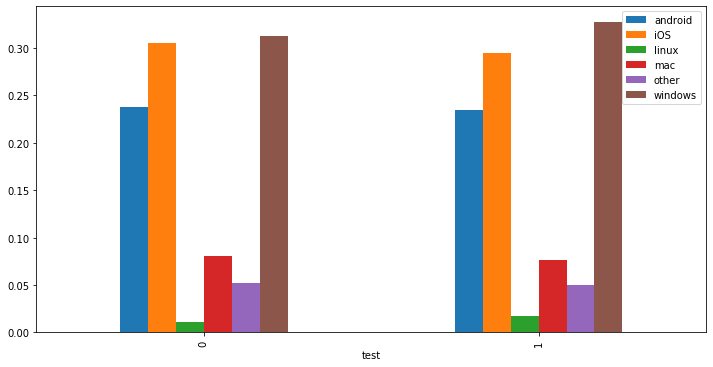

In [22]:
    #不同操作平台下的客户分布
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind = 'bar',ax=ax).legend(loc=1, prop={'size': 10})
plt.show()

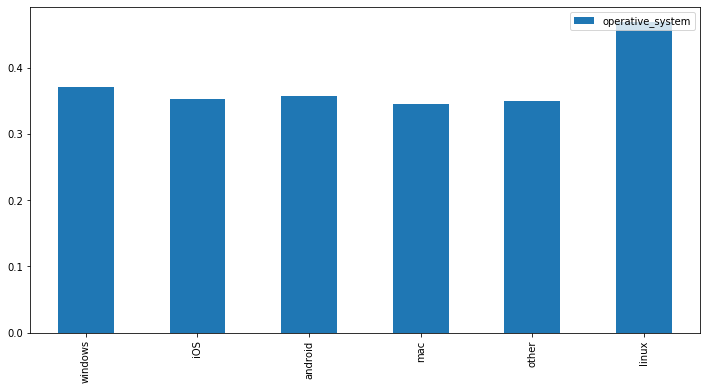

In [23]:
tmp = all_data.loc[all_data['test']==1]['operative_system'].value_counts()/all_data['operative_system'].value_counts()
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind = 'bar',ax=ax).legend(loc=1, prop={'size': 10})
plt.show()

从上述图表与数据中我们发现，此次a/b测试在客户渠道上，基本做到了随机性选择样本的要求。但在操作平台方面，Linux与Windows在实验组中有高于平均值的权重。这会影响到最后结论的有效性。

C. 解答问题

In [24]:
#a.涨价的整体影响
print(all_data.groupby('test')['converted'].mean())
print(all_data.groupby('test')['revenue'].mean())

test
0    0.019768
1    0.015446
Name: converted, dtype: float64
test
0    0.770967
1    0.911330
Name: revenue, dtype: float64


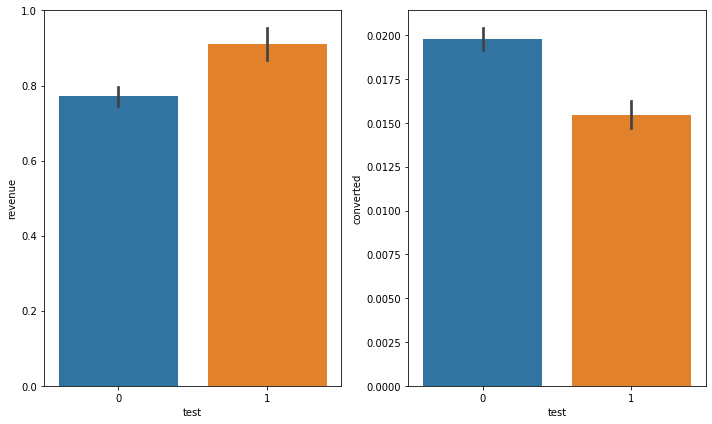

In [25]:
fig, ax = fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
sns.barplot(x='test',y='revenue',data=all_data,ax=ax[0])
sns.barplot(x='test',y='converted',data=all_data,ax=ax[1])
plt.tight_layout()
plt.show()

In [26]:
ctr_val = all_data[all_data['test'] == 0]['revenue'].values
exp_val = all_data[all_data['test'] == 1]['revenue'].values
print(ttest_ind(ctr_val, exp_val, axis=0, equal_var=False))

Ttest_indResult(statistic=-5.298877264308738, pvalue=1.1666887515733168e-07)


结论：涨价对转换率有一定的影响，将转换率从1.98%降到了1.54%左右。但人均销售额得到了提高，每个用户的人均销售额从77美分提高至了91美分。说明价格上涨的幅度足以抵消转换率的下降。

通过做t-test也发现，涨价确实对人均销售额产生了显著影响。（虽然spicy里的ttest是用的two-tailed test，但鉴于pvalue的数值较小，足以得出结论，因此无需做进一步调整）

总体来说，涨价确实能提高整体的销售额，但同时转换率也不可避免地下降。因此涨价与否取决于公司对产品未来的规划以及是否愿意以降低客户数量来换取销售额方面的增长。

需要注意的是，由于实验并没有做到完全的随机性样本选择，上面的结论可能需要更多实验的支撑。

In [27]:
#b.渠道与涨价的影响

In [28]:
amount = all_data.loc[all_data['test']==1]['revenue'].mean()-all_data.loc[all_data['test']==0]['revenue'].mean()
percent = amount/all_data.loc[all_data['test']==0]['revenue'].mean()*100
percent

18.206131352078685

In [29]:
amount2=(all_data.loc[all_data['test']==1].groupby(['source'])['revenue'].mean()-all_data.loc[all_data['test']==0].groupby(['source'])['revenue'].mean())
percent2= amount2/all_data.loc[all_data['test']==0].groupby(['source'])['revenue'].mean()*100
percent2

source
ads-bing           11.061907
ads-google         29.700771
ads-yahoo          18.894682
ads_facebook        9.049242
ads_other          31.546328
direct_traffic     10.534174
friend_referral    16.765548
seo-bing          -38.614808
seo-google         36.493428
seo-other           3.894448
seo-yahoo         -17.784541
seo_facebook       19.654927
Name: revenue, dtype: float64

结论：涨价对人均销售额的总体平均线提升为18%。对各个渠道做分析，发现不同渠道下，涨价对人均销售额的提高有不同的影响。具体来说，谷歌不论是seo还是广告，涨价对人均销售额的提升理论上都远高于平均值。有类似效果的还有通过其他渠道（others）的广告投发。而通过bing，facebook，和yahoo这几个渠道下得到的客户，涨价对人均销售额的提升效果总体上要低于平均值甚至会产生负面效果。

鉴于篇幅，不对以上数据做显著性检验。

In [30]:
#c.操作平台与涨价的关系
amount3=(all_data.loc[all_data['test']==1].groupby(['operative_system'])['revenue'].mean()-all_data.loc[all_data['test']==0].groupby(['operative_system'])['revenue'].mean())
percent3= amount3/all_data.loc[all_data['test']==0].groupby(['operative_system'])['revenue'].mean()*100
percent3

operative_system
android     20.982177
iOS         28.859449
linux     -100.000000
mac         16.438026
other       16.879529
windows     12.097261
Name: revenue, dtype: float64

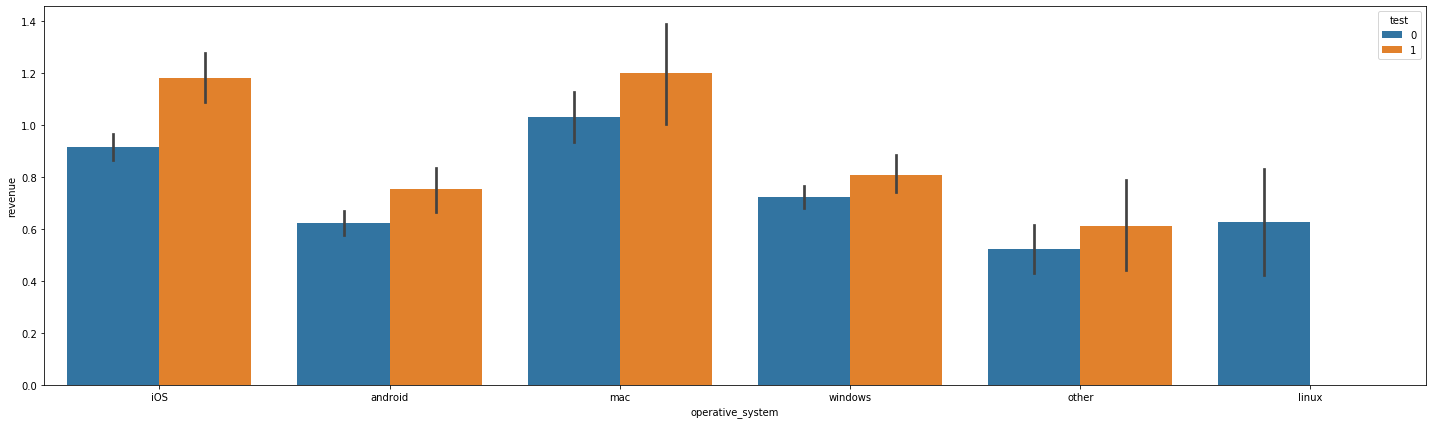

In [31]:
    #不同渠道下的客户人均销售额-图表
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x='operative_system',y='revenue',hue='test',data=all_data)
plt.tight_layout()
plt.show()

结论：不同平台下涨价对销售额的影响也有差异。具体来说，ios用户对价格的敏感度要低于平均值。同时，分析发现涨价对于移动端用户上的销售额提高要大于网页端用户。linux的用户对价格极为敏感，当价格上涨至59美金，1701名实验用户均没有选择付费（由于此项数据太过极端，不排除数据出错的可能）。

鉴于篇幅，不对以上数据做显著性检验。

整体结论：涨价对销售额有提升作用，同时分析发现不同渠道，不同操作系统下的客户对价格的敏感度也不一样。建议产品方在运用涨价策略时，对特定渠道（如Google）做重点关注，同时要加大对移动端用户的投资。对于某些细分群体（如Linux用户），涨价策略要谨慎使用。当然，这些细分策略是否得到运用要取决于相关的财务成本（如Google的运营成本是否显著高于其他渠道），这方面需要做进一步计算与分析。

补充:  渠道与操作平台这两个特征可能相关联，这会影响上述结论。鉴于篇幅不对此做分析。
     地理位置可能也对涨价效果有影响，并且未对实验组中客户地理位置的随机性做检查。
     用户访问网址时间可能会影响转化率。鉴于篇幅和有限的产品信息，决定不对这方面做分析。